In [1]:
import os
import cv2
import numpy as np
import imutils
import random
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

C:\Users\Mahmoud Kholief\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [14]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [15]:
from tqdm import tqdm
imagePaths = list(paths.list_images("dataset"))
data = []
labels = []

for imagePath in tqdm(imagePaths, total=len(imagePaths)):
    label = imagePath.split(os.path.sep)[-2]
    # print(label)

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 393.63it/s]


In [16]:
data = np.array(data)
data = np.array(data) / 255.0
labels = np.array(labels)

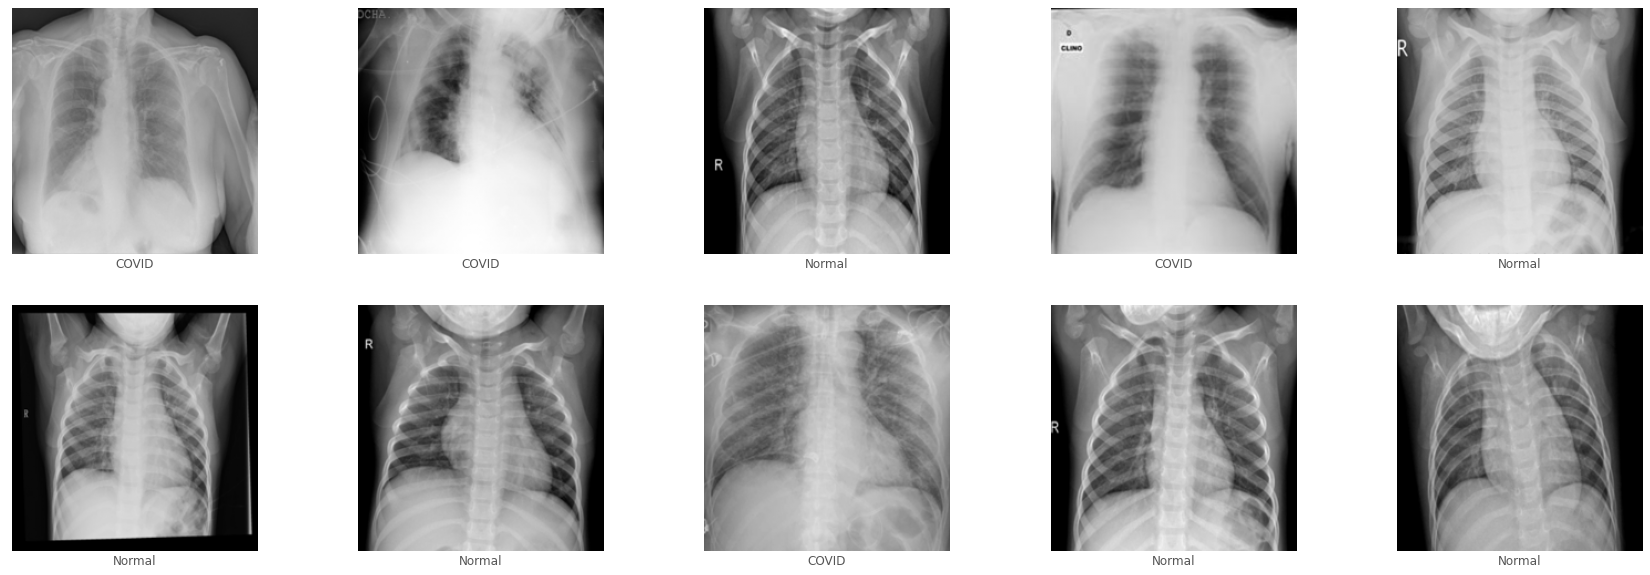

In [17]:
def plot_sample_from_dataset(images, labels,rows=5, colums=5, width=8,height=8):
  plt.figure(figsize=(width,height))
  for i in range(rows*colums):
    plt.subplot(rows,colums,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(0, len(labels)-1)
    plt.imshow(images[j], cmap=plt.cm.binary)
    plt.xlabel(labels[j])
  plt.show()

plot_sample_from_dataset(data, labels,rows=2, colums=5, width=30,height=10)

In [18]:
print("before binarizer")
print(labels[:5],'\n')
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("after binarizer")
print(labels[:5],'\n')
labels = to_categorical(labels)
print("after one hot encoding")
print(labels[:5])

before binarizer
['COVID' 'COVID' 'COVID' 'COVID' 'COVID'] 

after binarizer
[[0]
 [0]
 [0]
 [0]
 [0]] 

after one hot encoding
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [19]:
classes_names = lb.classes_
classes_number = len(lb.classes_)
print("number of classes : ",classes_number)
print("classes are : ",classes_names)

number of classes :  2
classes are :  ['COVID' 'Normal']


In [20]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainAug = ImageDataGenerator(
    # rescale= 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range=15,
    fill_mode="nearest")
# valAug = ImageDataGenerator(
#     rescale= 1./255)

In [21]:
baseModel = InceptionV3(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [22]:
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
H = model.fit(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(taestX, testY),
	validation_steps=(len(testX) // BS),
	epochs=10)

Epoch 1/10
200/200 [==============================] - 27s 134ms/step - loss: 0.4010 - accuracy: 0.8819 - val_loss: 0.1592 - val_accuracy: 0.9475
Epoch 2/10
200/200 [==============================] - 25s 126ms/step - loss: 0.2174 - accuracy: 0.9287 - val_loss: 0.1606 - val_accuracy: 0.9500
Epoch 3/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2015 - accuracy: 0.9319 - val_loss: 0.1260 - val_accuracy: 0.9525
Epoch 4/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1764 - accuracy: 0.9438 - val_loss: 0.1467 - val_accuracy: 0.9475
Epoch 5/10
200/200 [==============================] - 26s 128ms/step - loss: 0.1822 - accuracy: 0.9394 - val_loss: 0.1366 - val_accuracy: 0.9525
Epoch 6/10
200/200 [==============================] - 23s 117ms/step - loss: 0.1803 - accuracy: 0.9456 - val_loss: 0.1410 - val_accuracy: 0.9500
Epoch 7/10
200/200 [==============================] - 23s 117ms/step - loss: 0.1467 - accuracy: 0.9494 - val_loss: 0.1308 - val_ac

In [24]:
predictions = model.predict(testX, batch_size=BS)
predictions = np.argmax(predictions, axis=1)

print(classification_report(testY.argmax(axis=1), predictions,target_names=lb.classes_))

              precision    recall  f1-score   support

       COVID       0.92      0.99      0.95       199
      Normal       0.99      0.92      0.95       201

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



NameError: name 'arguments' is not defined

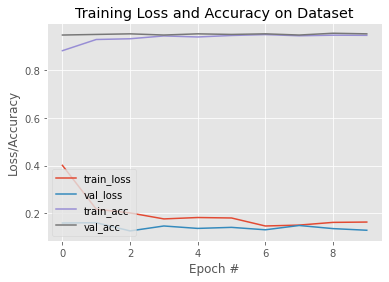

In [26]:
# plot the training loss and accuracy
N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(arguments["plot"])